<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем необходимые для выполнения проекта библиотеки и функции:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

Загрузим датасет и изучим информацию о нем:

In [2]:
df = pd.read_csv('/datasets/taxi.csv')
display(df.head())
display(df.describe())
df.info()
print()
print('Пропуски:')
print(df.isna().mean())
print()
print('Всего дубликатов:', df.duplicated().sum())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB

Пропуски:
datetime      0.0
num_orders    0.0
dtype: float64

Всего дубликатов: 0


Пропусков и дубликатов в данных нет. 

Тип данных в столбце datetime типа object - необходимо перевести в datetime. Также считаю целесообразным установить индекс таблицы, равным этому столбцу, и отсортируем таким образом, чтобы дата и время были расположены в хронологическом порядке. "Перезагрузим" таблицу:

In [3]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df = df.sort_index()
print(df.index.is_monotonic) #убедимся, что данные расположены в хронологическом порядке

True


Произведем ресемплирование данных по одному часу. В качестве агрегированного значения по каждому ряду примем сумму:

In [4]:
df = df.resample('1H').sum()

Данные готовы к анализу. Перейдем к нему:

## Анализ

Построим график нашего временного ряда:

<AxesSubplot:xlabel='datetime'>

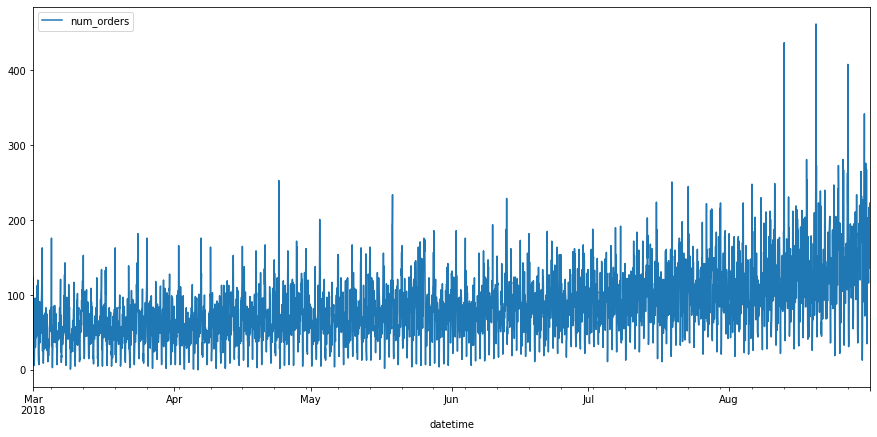

In [5]:
df.plot(figsize=(15,7)) 

Чтобы снизить колебания во временном ряду, используем скользящее среднее:

<AxesSubplot:xlabel='datetime'>

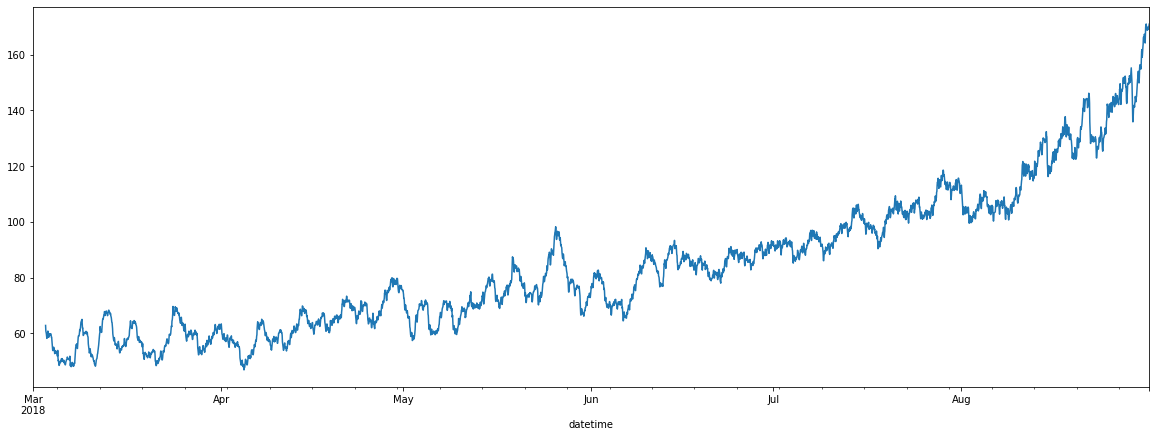

In [6]:
df['rolling_mean'] = df.rolling(50).mean() #экспериментально подобранный размер "окна"
df['rolling_mean'].plot(figsize=(20,7))

С каждым месяцем заказов все больше! Среднее меняется, значит временной ряд нельзя назвать стационарным. Изучим тренд и сезонность временного ряда:

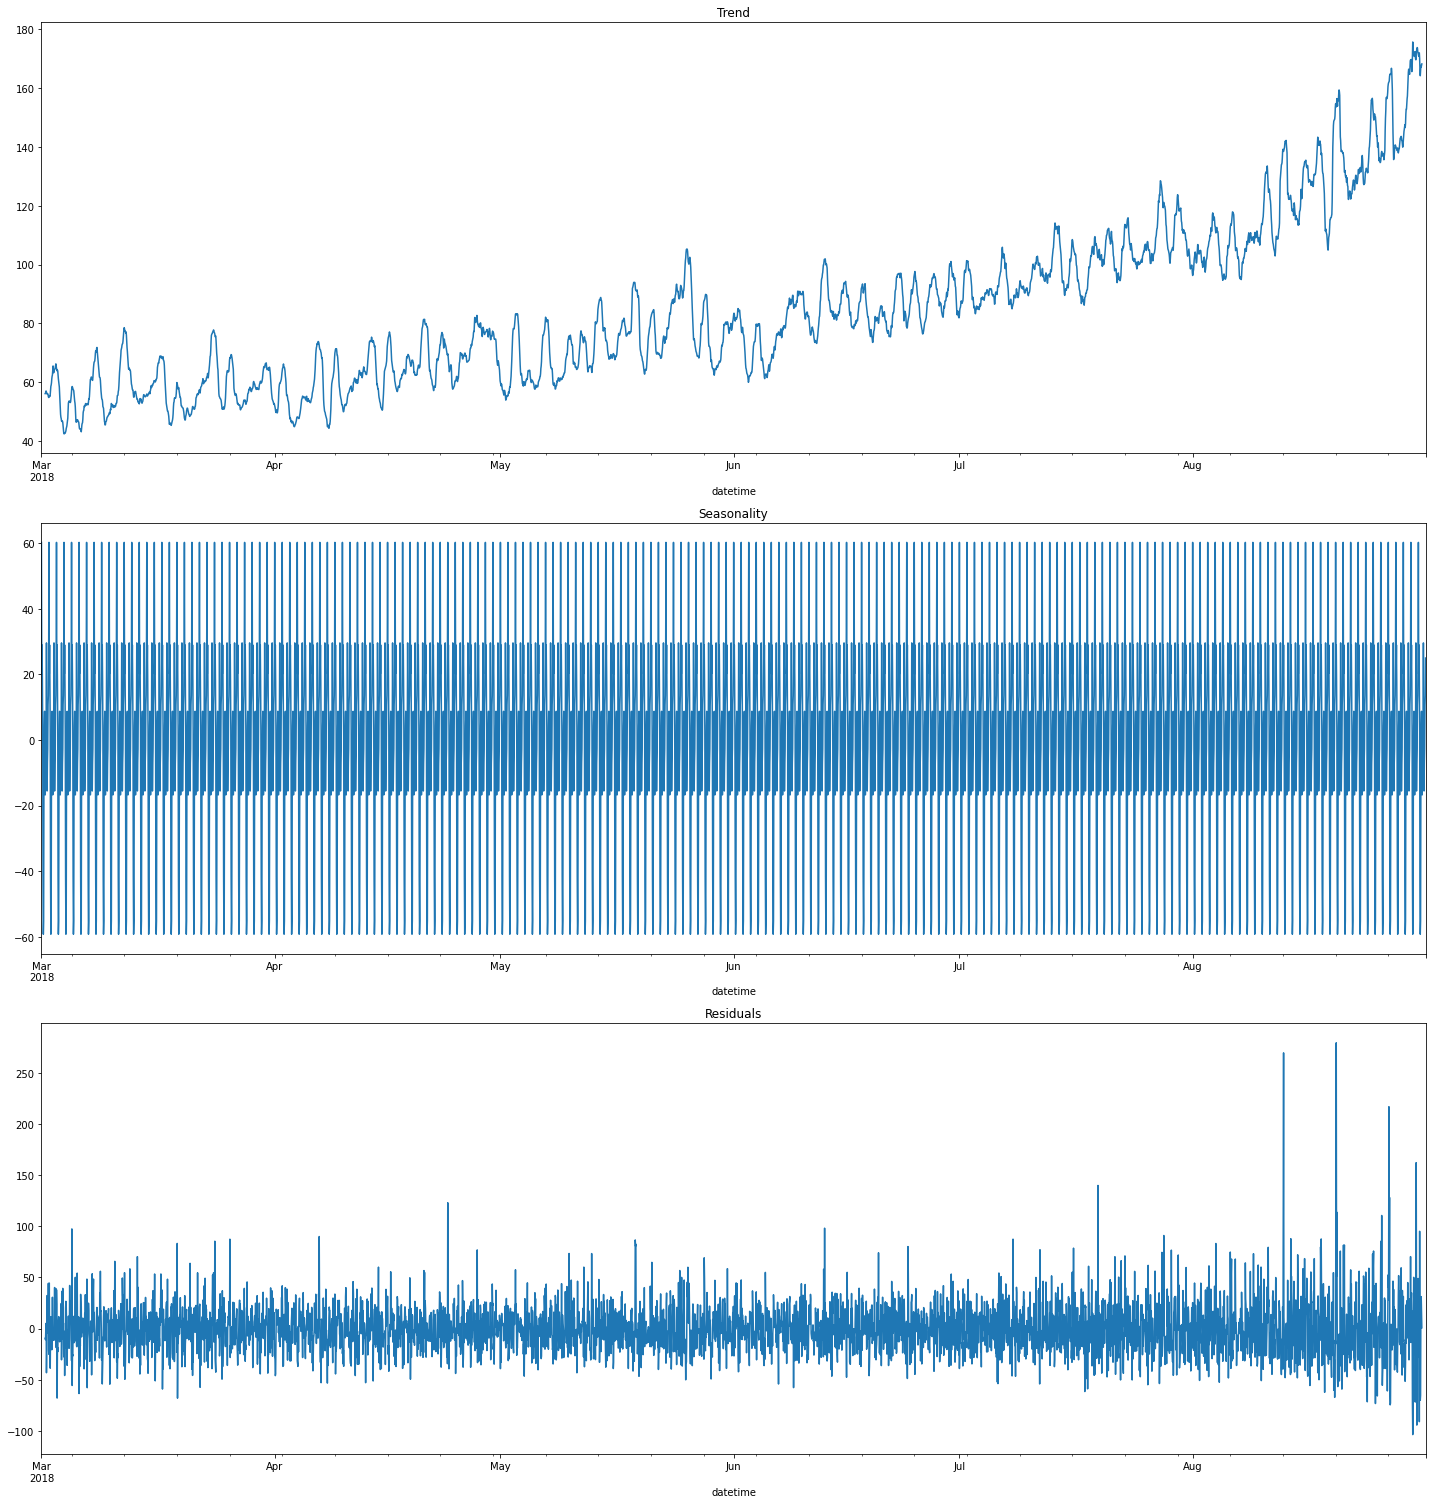

In [7]:
df = df.drop(columns = ['rolling_mean'], axis=1) #столбец со скользящим средним больше не понадобится
decomposed = seasonal_decompose(df)

plt.figure(figsize=(20, 21))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Изучим сезонность более подробно. Возьмем интервал в две недели:

<AxesSubplot:xlabel='datetime'>

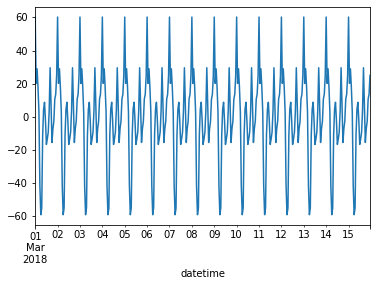

In [8]:
decomposed.seasonal['2018-03-01':'2018-03-15'].plot()

График получился не слишком информативным. Посмотрим сезонность на интервале нескольких дней:

<AxesSubplot:xlabel='datetime'>

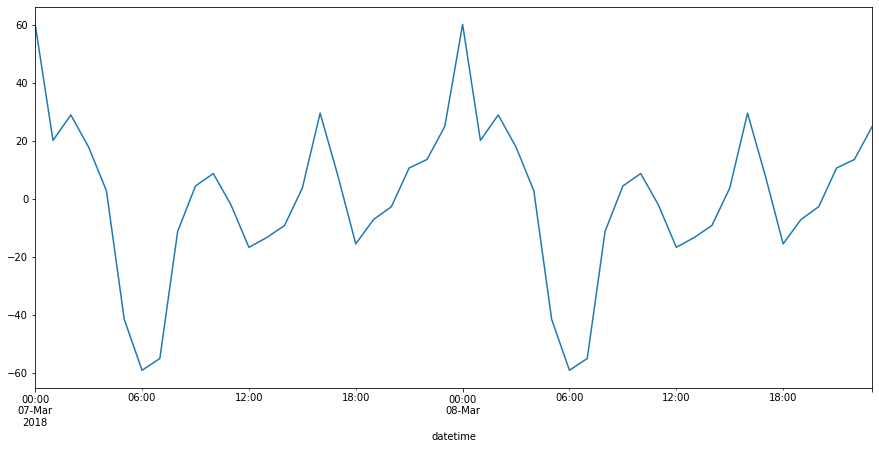

In [9]:
decomposed.seasonal['2018-03-07':'2018-03-08'].plot(figsize=(15,7)) #возьмем будний и выходной дни

Пик загруженности приходится на 00:00 - думаю, это связано с тем, что в столь позднее время уже не ходит общественный транспорт, либо люди настолько устают в дороге, что сил добираться на чем-то, кроме такси, не остается. Далее график убывает и достигает минимума в 6 утра (ночью рейсов меньше). После 6:00 заказов становится больше. Перейдем к обучению модели

## Обучение

Для обучения модели необходимо создать признаки. Запишем функцию:

In [10]:
def make_features(df, max_lag, rolling_mean_size):
    #df['month'] = df.index.month #календарные признаки
    #df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag) # "отстающие значения"

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean() #скользящее среднее
    df.dropna(inplace=True) #для дальнейшего обучения удалим строки с пропусками
    
    return df

In [11]:
make_features(df, 2, 24)

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,56.833333
2018-03-02 01:00:00,120,4,1,90.0,58.0,55.416667
2018-03-02 02:00:00,75,4,2,120.0,90.0,56.875000
2018-03-02 03:00:00,64,4,3,75.0,120.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,56.958333
...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,207.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,136.0,168.041667


Разделим данные на обучающую и тестовую выборки в соотношении 9:1. Выделим признаки и целевой признак:

In [12]:
df_train, df_test = train_test_split(df, shuffle=False, test_size=0.1)
features_train = df_train.drop(['num_orders'], axis=1)
target_train = df_train['num_orders']
features_test = df_test.drop(['num_orders'], axis=1)
target_test = df_test['num_orders']

Попробуем спрогнозировать временной ряд без обучения. Для RMSE рассмотрим прогнозы медианой и средним:

In [13]:
pred_median = np.ones(df_test.shape) * df_train['num_orders'].median() #прогноз медианой
print("RMSE для прогноза медианой:", mse(df_test, pred_median)**0.5)
pred_mean = np.ones(df_test.shape) * df_train['num_orders'].mean() #прогноз средним
print("RMSE для прогноза средним:", mse(df_test, pred_mean)**0.5)

RMSE для прогноза медианой: 77.80978372572991
RMSE для прогноза средним: 76.9843006177663


Теперь попробуем спрогнозировать новое значение предыдущим значением ряда. Этот метод не зависит от метрики:

In [14]:
pred_previous = df_test.shift()
pred_previous.iloc[0] = df_train.iloc[-1]
print("RMSE:", mse(df_test, pred_previous)**0.5)

RMSE: 41.72086908545135


Оба опробованных способа не позволили достичь требуемого значения метрики RMSE. Напишем функцию для обучения моделей:

In [15]:
def give_me_rmse(mod, name):
    model = mod
    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    rmse_train = mse(target_train, pred_train)**0.5
    print(f'{name}. RMSE на тренировочной выборке: {rmse_train}')
    pred_test = model.predict(features_test)
    rmse_test = mse(target_test, pred_test)**0.5
    print(f'{name}. RMSE на тестовой выборке: {rmse_test}')

Перйедем к тестированию моделей:

## Тестирование

**Линейная регрессия**

In [16]:
%%time
give_me_rmse(LinearRegression(), 'LinearRegression')

LinearRegression. RMSE на тренировочной выборке: 30.887638490679436
LinearRegression. RMSE на тестовой выборке: 51.29636818907293
CPU times: user 8.65 ms, sys: 930 µs, total: 9.58 ms
Wall time: 35.4 ms


RMSE больше требуемого. Пока попробуем обучить другие модели. Если и они не дадут требуемого результата, то перейдем к подбору параметров.

**Случайный лес**

In [17]:
%%time
give_me_rmse(RandomForestRegressor(), 'RandomForestRegressor')

RandomForestRegressor. RMSE на тренировочной выборке: 8.621274808688277
RandomForestRegressor. RMSE на тестовой выборке: 46.041274254738
CPU times: user 992 ms, sys: 8.38 ms, total: 1 s
Wall time: 1.01 s


Получено требуемое значение RMSE. Попробуем его улучшить, подобрав параметры:

In [18]:
%%time
result = 44
best_depth = 0
best_est = 0
for est in range(1,15):
    for depth in (1,15):
        model = RandomForestRegressor(n_estimators = est, max_depth=depth)
        model.fit(features_train, target_train)
        pred_test = model.predict(features_test)
        rmse_test = mse(target_test, pred_test)**0.5
        if rmse_test < result:
            result = rmse_test
            best_depth = depth
            best_est = est
print(f'Наименьшее значение метрики RMSE={result} при количестве деревьев {best_est} и глубине {best_depth}')


Наименьшее значение метрики RMSE=44 при количестве деревьев 0 и глубине 0
CPU times: user 1.23 s, sys: 4.07 ms, total: 1.23 s
Wall time: 1.24 s


В результате подбора параметров удалось улучшить значение RMSE.

# Вывод

На первом этапе работы были рагружены и предобработаны данные, произведено ресемплирование по одному часу.

В результате анализа данных определены тренд и сезонность изучаемого временного ряда. Также установлено, что ряд не является стационарным.

Далее мы перешли к предсказаниям модели. Вначале была предпринята попытка получить требуемое значение RMSE без обучения, но успеха она не достигла. В процессе обучения были исследованы модели линейной регрессии и случайного леса. Случайный лес позволил получить нам требуемое значение RMSE, после чего оно было улучшено путем подбора параметров.

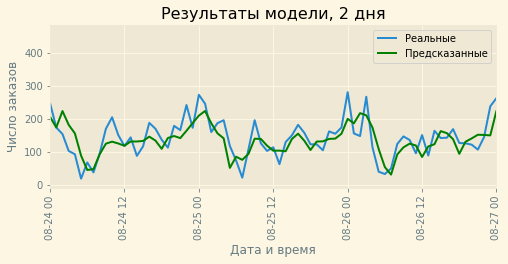

<div class="alert alert-block alert-info">
<b>Комментарий:</b> Построил график в масштабе трех дней. Ошибки в предсказании "пиковых" часов - модель предсказывает меньшее количество такси, чем требуется
</div>

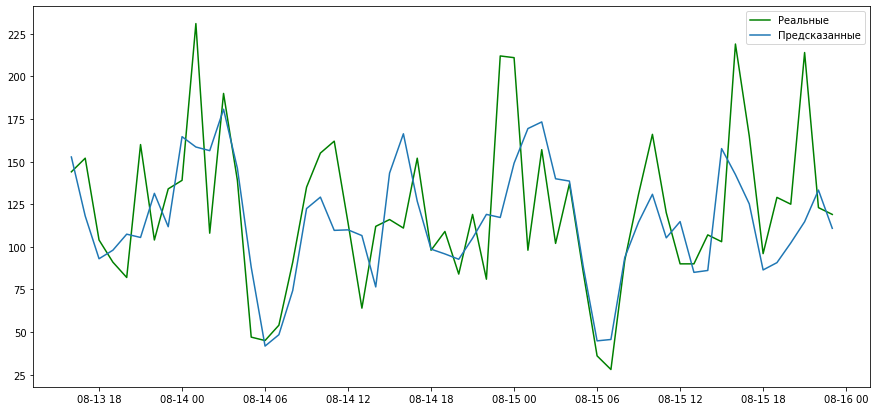

In [19]:
fig, ax = plt.subplots(figsize = (15,7))
plt.plot(target_test['2018-08-13':'2018-08-15'].index, target_test[:56], label='Реальные', color="green")
plt.plot(target_test['2018-08-13':'2018-08-15'].index, pred_test[:56], label='Предсказанные')
ax.legend()